In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal
from scipy.io import wavfile
import io
from PIL import Image
import librosa

test_file = '/home/george-vengrovski/Documents/canary_attention/llb3_0002_2018_04_23_14_18_03.wav'

#### For tuning parameters on a test file, and defining several functions

(88, 3281)
17189.387755102038
5.239069721152709


/tmp/ipykernel_12143/1602997797.py:38: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  print(librosa.get_duration(filename=test_file) * 1000)
/tmp/ipykernel_12143/1602997797.py:40: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  ms_per_x_pixels = (librosa.get_duration(filename=test_file) * 1000) / np_sonogram.shape[1]


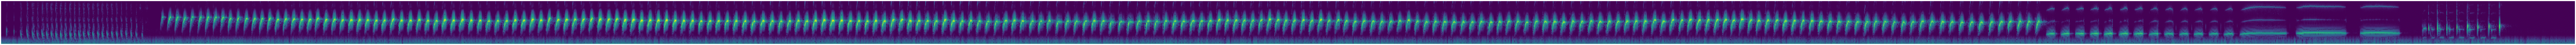

In [33]:
# create sonogram of the whole song 
 
# wav to numpy array
def wav_to_numpy(file):
    rate, data = wavfile.read(file)
    return rate, data

def createSonogram(songfile):
    data = wav_to_numpy(songfile)
    rate = data[0]
    data = data[1]

    f, t, Sxx = signal.spectrogram(data, rate, nfft=512, noverlap=25, scaling="density")

    fmin = 400 # Hz
    fmax = 8000 # Hz
    freq_slice = np.where((f >= fmin) & (f <= fmax))

    # keep only frequencies of interest
    f   = f[freq_slice]
    Sxx = Sxx[freq_slice,:][0]

    Sxx = np.log(Sxx + 1)

    np_sonogram = np.array(Sxx, dtype="float32")
    # figure size in inches 1,1
    plt.figure(figsize=(300,5))

    plt.pcolormesh(Sxx)
    plt.axis('off')
    return plt, np_sonogram 

# np sonogram is the numpy array of the sonogram
plt, np_sonogram = createSonogram(test_file)

print(np.shape(np_sonogram))

print(librosa.get_duration(filename=test_file) * 1000)

ms_per_x_pixels = (librosa.get_duration(filename=test_file) * 1000) / np_sonogram.shape[1]
print(ms_per_x_pixels)

(3281,)
(3537,)


<Figure size 5000x500 with 0 Axes>

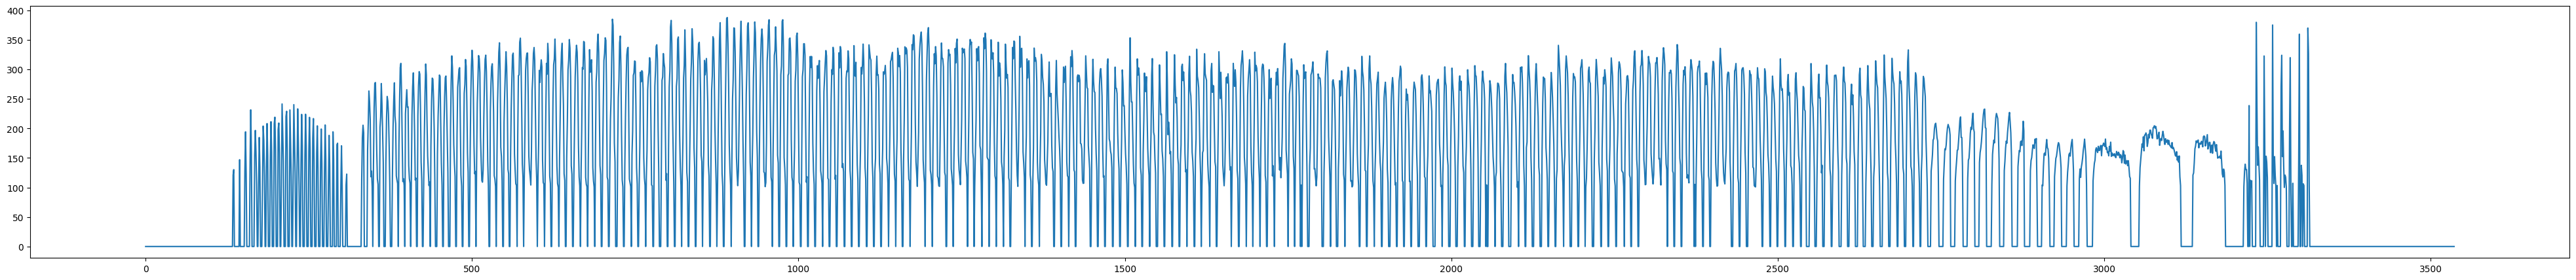

In [36]:
# reverse the axis of the np array dim1 becomes dim 0 and vice versa
np_sonogram = np_sonogram.T

vertical_sum = np.sum(np_sonogram, axis=1)

print(vertical_sum.shape)

# for every vertical sum if below 100, set to 0
for i in range(len(vertical_sum)):
    if vertical_sum[i] < 100:
        vertical_sum[i] = 0

# x axis is the time axis
# figure dims the same as below
plt.figure(figsize=(50,5))
plt.plot(vertical_sum) 

vertical_sum_padded = np.zeros((len(vertical_sum) + 256))
vertical_sum_padded[0:128] = 0
vertical_sum_padded[-128:] = 0

vertical_sum_padded[128:-128] = vertical_sum

plt.clf()
plt.figure(figsize=(50,5))
plt.plot(vertical_sum_padded)

print(vertical_sum_padded.shape)

(129, 3282)


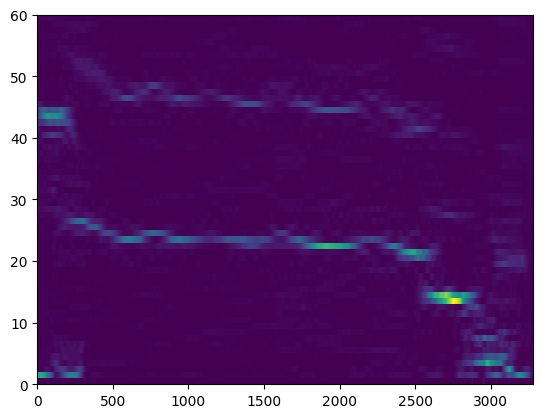

In [35]:
vertical_sum_padded = np.log(vertical_sum_padded + 1)


f, t, Sxx = signal.spectrogram(vertical_sum_padded, 1, nfft=256, noverlap=255, scaling="density")


print(np.shape(Sxx))

# remove the super high periodicities that don't really exist
Sxx = Sxx[:60]

plt.pcolormesh(Sxx)

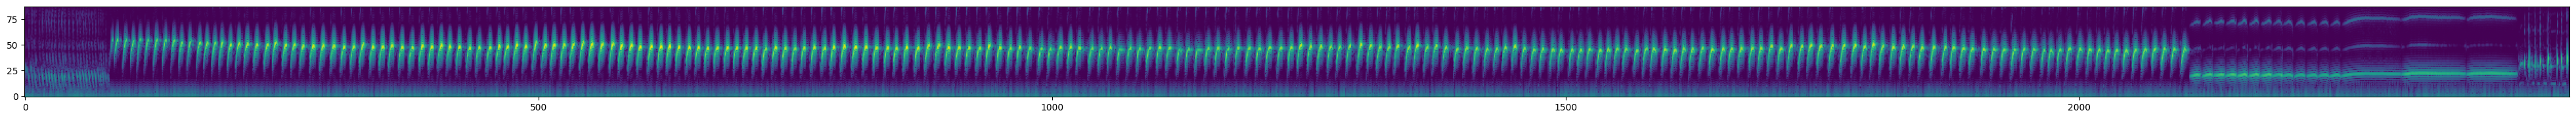

In [9]:
from matplotlib.pyplot import axis 

window_size = 1
threshold = 0

# window slides over vertical sum, takes the average and keeps it if it is above threshold
def sliding_window_average(vertical_sum, window_size, threshold):
    window = np.ones(int(window_size))/float(window_size)
    y = np.convolve(vertical_sum, window, 'same')
    y = np.where(y > threshold, y, 0)
    return y

y = sliding_window_average(vertical_sum, window_size, threshold)

# get the indices of the locations where the vertical sum is above threshold
indices = np.where(y > 0)[0]
plt.figure(figsize=(50,5))
plt.imshow(np_sonogram[indices].T, origin='lower')